**Acquiring and Processing Information on the World's Largest Banks**

\
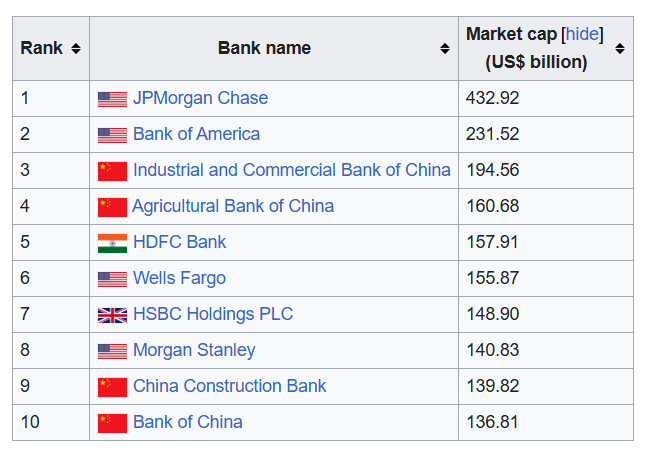

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import sqlite3

In [2]:
url = "https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks"

In [3]:
%%bash
wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-PY0221EN-Coursera/labs/v2/exchange_rate.csv

--2025-02-15 07:29:53--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-PY0221EN-Coursera/labs/v2/exchange_rate.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45 [text/csv]
Saving to: ‘exchange_rate.csv.1’

     0K                                                       100% 23.6M=0s

2025-02-15 07:29:54 (23.6 MB/s) - ‘exchange_rate.csv.1’ saved [45/45]



In [4]:
%%bash
head exchange_rate.csv

Currency,Rate
EUR,0.93
GBP,0.8
INR,82.95


In [5]:
db_name = "banks.db"
table_name = "largest_banks"
log_file = "etl_log.txt"
csv_file = "largest_banks.csv"
table_attributes = ["name", "mc_usd_billion"]
table_attributes_final = ["name", "mc_usd_billion", "mc_gbp_billion", "mc_eur_billion", "mc_inr_billion"]

In [6]:
def extract(url:str, table_attributes:list) -> pd.DataFrame:
    df = pd.DataFrame(columns=table_attributes)
    page = requests.get(url).text
    data = BeautifulSoup(page, "html.parser")
    table = data.find_all("tbody")[0]
    rows = table.find_all("tr")
    for row in rows:
        col = row.find_all("td")
        if len(col) == 0:
            continue
        name = col[1].contents[2]
        mc_usd_billion = float(col[2].text.strip())
        bank_dict = {
            "name": name,
            "mc_usd_billion": mc_usd_billion
        }
        df1 = pd.DataFrame(bank_dict, index=[0])
        df = pd.concat([df, df1], ignore_index=True)
    return df

In [7]:
def transform(df:pd.DataFrame) -> pd.DataFrame:
    df_exchange = pd.read_csv("exchange_rate.csv", header=0)
    df_exchange["Rate"] = df_exchange["Rate"].astype(float)
    df["mc_usd_billion"] = np.round(df["mc_usd_billion"].astype(float), 2)
    df["mc_gbp_billion"] = np.round(df["mc_usd_billion"] * df_exchange[df_exchange["Currency"] == "GBP"].Rate.values[0], 2)
    df["mc_eur_billion"] = np.round(df["mc_usd_billion"] * df_exchange[df_exchange["Currency"] == "EUR"].Rate.values[0], 2)
    df["mc_inr_billion"] = np.round(df["mc_usd_billion"] * df_exchange[df_exchange["Currency"] == "INR"].Rate.values[0], 2)
    df = df[table_attributes_final]
    return df

In [8]:
def load_to_csv(df:pd.DataFrame, csv_file:str) -> None:
    df.to_csv(csv_file, index=False)

In [9]:
def load_to_sql(df:pd.DataFrame, db_name:str, table_name:str) -> None:
    conn = sqlite3.connect(db_name)
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    conn.close()

In [10]:
def log(message:str) -> None:
    timestamp_format = "%Y-%b-%d %H:%M:%S"
    now = datetime.now()
    timestamp = now.strftime(timestamp_format)
    with open(log_file, "a") as f:
        f.write(f"{timestamp} ,{message}\n")

In [11]:
def run_query(query:str, db_name:str) -> pd.DataFrame:
    conn = sqlite3.connect(db_name)
    df = pd.read_sql(query, conn)
    conn.close()
    return df

In [12]:
def main():
    log("ETL Job Started")

    log("Extract phase Started")
    df = extract(url, table_attributes)
    log("Extract phase Ended")

    log("Transform phase Started")
    df = transform(df)
    log("Transform phase Ended")

    log("Load phase Started")
    log("Load to CSV Started")
    load_to_csv(df, csv_file)
    log("Load to CSV Ended")
    log("Load to Database Started")
    load_to_sql(df, db_name, table_name)
    log("Load to Database Ended")

    log("ETL Job Ended")


In [13]:
main()

<ipython-input-6-8e3f2d3313ee>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df1], ignore_index=True)


In [14]:
query = f"select * from {table_name}"
run_query(query, db_name)

,name,mc_usd_billion,mc_gbp_billion,mc_eur_billion,mc_inr_billion
0,JPMorgan Chase,432.92,346.34,402.62,35910.71
1,Bank of America,231.52,185.22,215.31,19204.58
2,Industrial and Commercial Bank of China,194.56,155.65,180.94,16138.75
3,Agricultural Bank of China,160.68,128.54,149.43,13328.41
4,HDFC Bank,157.91,126.33,146.86,13098.63
5,Wells Fargo,155.87,124.70,144.96,12929.42
6,HSBC Holdings PLC,148.90,119.12,138.48,12351.26
7,Morgan Stanley,140.83,112.66,130.97,11681.85
8,China Construction Bank,139.82,111.86,130.03,11598.07
9,Bank of China,136.81,109.45,127.23,11348.39


In [15]:
%%bash
head largest_banks.csv

name,mc_usd_billion,mc_gbp_billion,mc_eur_billion,mc_inr_billion
JPMorgan Chase,432.92,346.34,402.62,35910.71
Bank of America,231.52,185.22,215.31,19204.58
Industrial and Commercial Bank of China,194.56,155.65,180.94,16138.75
Agricultural Bank of China,160.68,128.54,149.43,13328.41
HDFC Bank,157.91,126.33,146.86,13098.63
Wells Fargo,155.87,124.7,144.96,12929.42
HSBC Holdings PLC,148.9,119.12,138.48,12351.26
Morgan Stanley,140.83,112.66,130.97,11681.85
China Construction Bank,139.82,111.86,130.03,11598.07
